# Machine-learning Notebook - experimentation for calculating pick depth prediction from pick label classification prediction
- Machine_Learning_vB2_20170802
- A cleaner version of Machine_Learning_vB in the same folder
- preceeded by feature creation notebooks

In [258]:
import pandas as pd
import numpy as np
import itertools
# import matplotlib.pyplot as plt
# %matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
import dask
import dask.dataframe as dd
from dask.distributed import Client
# import pdvega
# import vega
import random
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import mean_squared_error

In [259]:
import multiprocessing

In [260]:
print(welly.__version__)
print(dask.__version__)
print(pd.__version__)

0.3.5
0.18.2
0.23.3


In [261]:
#### Adding this bit to silence an error that was causing the notebook to have a dead kernal
#### This is an unsafe solution but couldn't get any  of the "right solutions" to work!
#### Ended up using this = https://www.kaggle.com/c/bosch-production-line-performance/discussion/25082
#### Other solutions = https://github.com/dmlc/xgboost/issues/1715 but the solution here didn't seem to work for me?


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [262]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

In [263]:
knn_dir = "../WellsKNN/"
load_dir = "../loadLAS"
features_dir = "../createFeatures/"
machine_learning_dir = "../Pre_ML_Rebalance_Splitting/"

## If you open this notebook fresh and jump to a point below where a pick file is read in, you still need to load everything above! 

----------

### Load dataframes for Machine-Learning via a HDF5 file

train_X
train_y
test_X
test_y

In [264]:
h5_to_load = 'df_all_Col_preSplit_wTrainTest_ClassBalanced_PreML_20181003.h5'
train_X = pd.read_hdf(machine_learning_dir+h5_to_load, 'train_X')
train_y = pd.read_hdf(machine_learning_dir+h5_to_load, 'train_y')
test_X = pd.read_hdf(machine_learning_dir+h5_to_load, 'test_X')
test_y = pd.read_hdf(machine_learning_dir+h5_to_load, 'test_y')

train_index = pd.read_hdf(machine_learning_dir+h5_to_load, 'train_index')
test_index = pd.read_hdf(machine_learning_dir+h5_to_load, 'test_index')

In [265]:
print(len(test_X))
print(len(test_y))
print(len(test_index))

255885
255885
255885


In [266]:
preSplitpreBal = pd.read_hdf(machine_learning_dir+h5_to_load, 'preSplitpreBal')


In [267]:
train_X.head()

,DEPT,DPHI,GR,ILD,NPHI,TopHelper_HorID_Qual,TopTarget_Qual,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,DistFrom_NN1ThickPredTopDepth_toRowDept,FromTopWell,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,NPHI_min_5winSize_dirAroundMin,NPHI_min_5winSize_dirAboveMin,NPHI_min_5winSize_dirAroundMax,NPHI_min_5winSize_dirAboveMax,NPHI_min_5winSize_dirAroundMean,NPHI_min_5winSize_dirAboveMean,NPHI_min_5winSize_dirAbovenLarge,NPHI_min_5winSize_dirAroundnLarge,NPHI_min_7winSize_dirAroundMin,NPHI_min_7winSize_dirAboveMin,NPHI_min_7winSize_dirAroundMax,NPHI_min_7winSize_dirAboveMax,NPHI_min_7winSize_dirAroundMean,NPHI_min_7winSize_dirAboveMean,NPHI_min_7winSize_dirAbovenLarge,NPHI_min_7winSize_dirAroundnLarge,NPHI_min_11winSize_dirAroundMin,NPHI_min_11winSize_dirAboveMin,NPHI_min_11winSize_dirAroundMax,NPHI_min_11winSize_dirAboveMax,NPHI_min_11winSize_dirAroundMean,NPHI_min_11winSize_dirAboveMean,NPHI_min_11winSize_dirAbovenLarge,NPHI_min_11winSize_dirAroundnLarge,NPHI_min_21winSize_dirAroundMin,NPHI_min_21winSize_dirAboveMin,NPHI_min_21winSize_dirAroundMax,NPHI_min_21winSize_dirAboveMax,NPHI_min_21winSize_dirAroundMean,NPHI_min_21winSize_dirAboveMean,NPHI_min_21winSize_dirAbovenLarge,NPHI_min_21winSize_dirAroundnLarge,DPHI_min_5winSize_dirAroundMin,DPHI_min_5winSize_dirAboveMin,DPHI_min_5winSize_dirAroundMax,DPHI_min_5winSize_dirAboveMax,DPHI_min_5winSize_dirAroundMean,DPHI_min_5winSize_dirAboveMean,DPHI_min_5winSize_dirAbovenLarge,DPHI_min_5winSize_dirAroundnLarge,DPHI_min_7winSize_dirAroundMin,DPHI_min_7winSize_dirAboveMin,DPHI_min_7winSize_dirAroundMax,DPHI_min_7winSize_dirAboveMax,DPHI_min_7winSize_dirAroundMean,DPHI_min_7winSize_dirAboveMean,DPHI_min_7winSize_dirAbovenLarge,DPHI_min_7winSize_dirAroundnLarge,DPHI_min_11winSize_dirAroundMin,DPHI_min_11winSize_dirAboveMin,DPHI_min_11winSize_dirAroundMax,DPHI_min_11winSize_dirAboveMax,DPHI_min_11winSize_dirAroundMean,DPHI_min_11winSize_dirAboveMean,DPHI_min_11winSize_dirAbovenLarge,DPHI_min_11winSize_dirAroundnLarge,DPHI_min_21winSize_dirAroundMin,DPHI_min_21winSize_dirAboveMin,

--------------------

In [268]:
preSplitpreBal.head()

,DEPT,DPHI,GR,ILD,NPHI,UWI,trainOrTest,TopTarget_DEPTH,TopHelper_HorID_Qual,TopTarget_Qual,NN1_topTarget_DEPTH,NN1_TopHelper_DEPTH,NN1_thickness,topTarget_Depth_predBy_NN1thick,class_DistFrPick_TopTarget,DistFrom_NN1ThickPredTopDepth_toRowDept,FromTopWell,GR_min_5winSize_dirAroundMin,GR_min_5winSize_dirAboveMin,GR_min_5winSize_dirAroundMax,GR_min_5winSize_dirAboveMax,GR_min_5winSize_dirAroundMean,GR_min_5winSize_dirAboveMean,GR_min_5winSize_dirAbovenLarge,GR_min_5winSize_dirAroundnLarge,GR_min_7winSize_dirAroundMin,GR_min_7winSize_dirAboveMin,GR_min_7winSize_dirAroundMax,GR_min_7winSize_dirAboveMax,GR_min_7winSize_dirAroundMean,GR_min_7winSize_dirAboveMean,GR_min_7winSize_dirAbovenLarge,GR_min_7winSize_dirAroundnLarge,GR_min_11winSize_dirAroundMin,GR_min_11winSize_dirAboveMin,GR_min_11winSize_dirAroundMax,GR_min_11winSize_dirAboveMax,GR_min_11winSize_dirAroundMean,GR_min_11winSize_dirAboveMean,GR_min_11winSize_dirAbovenLarge,GR_min_11winSize_dirAroundnLarge,GR_min_21winSize_dirAroundMin,GR_min_21winSize_dirAboveMin,GR_min_21winSize_dirAroundMax,GR_min_21winSize_dirAboveMax,GR_min_21winSize_dirAroundMean,GR_min_21winSize_dirAboveMean,GR_min_21winSize_dirAbovenLarge,GR_min_21winSize_dirAroundnLarge,ILD_min_5winSize_dirAroundMin,ILD_min_5winSize_dirAboveMin,ILD_min_5winSize_dirAroundMax,ILD_min_5winSize_dirAboveMax,ILD_min_5winSize_dirAroundMean,ILD_min_5winSize_dirAboveMean,ILD_min_5winSize_dirAbovenLarge,ILD_min_5winSize_dirAroundnLarge,ILD_min_7winSize_dirAroundMin,ILD_min_7winSize_dirAboveMin,ILD_min_7winSize_dirAroundMax,ILD_min_7winSize_dirAboveMax,ILD_min_7winSize_dirAroundMean,ILD_min_7winSize_dirAboveMean,ILD_min_7winSize_dirAbovenLarge,ILD_min_7winSize_dirAroundnLarge,ILD_min_11winSize_dirAroundMin,ILD_min_11winSize_dirAboveMin,ILD_min_11winSize_dirAroundMax,ILD_min_11winSize_dirAboveMax,ILD_min_11winSize_dirAroundMean,ILD_min_11winSize_dirAboveMean,ILD_min_11winSize_dirAbovenLarge,ILD_min_11winSize_dirAroundnLarge,ILD_min_21winSize_dirAroundMin,ILD_min_21winSize_dirAboveMin,ILD_min_21winSize_dirAroundMax,ILD_min_21winSize_dirAboveMax,ILD_min_21winSize_dirAroundMean,ILD_min_21winSize_dirAboveMean,ILD_min_21winSize_dirAbovenLarge,ILD_min_21winSize_dirAroundnLarge,NPHI_min_5winSize_dirAroundMin,NPHI_min_5winSize_dirAboveMin,NPHI_min_5winSize_dirAroundMax,NPHI_min_5winSize_dirAboveMax,NPHI_min_5winSize_dirAroundMean,NPHI_min_5winSize_dirAboveMean,NPHI_min_5winSize_dirAbovenLarge,NPHI_min_5winSize_dirAroundnLarge,NPHI_min_7winSize_dirAroundMin,NPHI_min_7winSize_dirAboveMin,NPHI_min_7winSize_dirAroundMax,NPHI_min_7winSize_dirAboveMax,NPHI_min_7winSize_dirAroundMean,NPHI_min_7winSize_dirAboveMean,NPHI_min_7winSize_dirAbovenLarge,NPHI_min_7winSize_dirAroundnLarge,NPHI_min_11winSize_dirAroundMin,NPHI_min_11winSize_dirAboveMin,NPHI_min_11winSize_dirAroundMax,NPHI_min_11winSize_dirAboveMax,NPHI_min_11winSize_dirAroundMean,NPHI_min_11winSize_dirAboveMean,NPHI_min_11winSize_dirAbovenLarge,NPHI_min_11winSize_dirAroundnLarge,NPHI_min_21winSize_dirAroundMin,NPHI_min_21winSize_dirAboveMin,NPHI_min_21winSize_dirAroundMax,NPHI_min_21winSize_dirAboveMax,NPHI_min_21winSize_dirAroundMean,NPHI_min_21winSize_dirAboveMean,NPHI_min_21winSize_dirAbovenLarge,NPHI_min_21winSize_dirAroundnLarge,DPHI_min_5winSize_dirAroundMin,DPHI_min_5winSize_dirAboveMin,DPHI_min_5winSize_dirAroundMax,DPHI_min_5winSize_dirAboveMax,DPHI_min_5winSize_dirAroundMean,DPHI_min_5winSize_dirAboveMean,DPHI_min_5winSize_dirAbovenLarge,DPHI_min_5winSize_dirAroundnLarge,DPHI_min_7winSize_dirAroundMin,DPHI_min_7winSize_dirAboveMin,DPHI_min_7winSize_dirAroundMax,DPHI_min_7winSize_dirAboveMax,DPHI_min_7winSize_dirAroundMean,DPHI_min_7winSize_dirAboveMean,DPHI_min_7winSize_dirAbovenLarge,DPHI_min_7winSize_dirAroundnLarge,DPHI_min_11winSize_dirAroundMin,DPHI_min_11winSize_dirAboveMin,DPHI_min_11winSize_dirAroundMax,DPHI_min_11winSize_dirAboveMax,DPHI_min_11winSize_dirAroundMean,DPHI_min_11winSize_dirAboveMean,DPHI_min_11winSize_dirAbovenLarge,DPHI_min_11winSize_dirAroundnLarge,DPHI

In [269]:
seed = 123

In [270]:
# .values.ravel()
model = XGBClassifier(
    gamma=0, 
    reg_alpha=0.3, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3,n_jobs=8)



In [271]:
model.fit(train_X,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=300,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

## Class Prediction Results for training dataframe or X

In [272]:
result_train = model.predict(train_X)
result_train

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([  0,   0,   0, ...,  95, 100, 100])

In [273]:
train_y_indexValues = train_y.index.values
df_result_train = pd.DataFrame(result_train, index=train_y_indexValues, columns=['TopTarget_Pick_pred'])
df_results_train_ = pd.concat([train_y, df_result_train], axis=1)

In [274]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [275]:
df_results_train_

,class_DistFrPick_TopTarget,TopTarget_Pick_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [276]:
accuracy = accuracy_score(df_results_train_['class_DistFrPick_TopTarget'], df_results_train_['TopTarget_Pick_pred'])

In [277]:
accuracy

0.8677172084815397

## Class Prediction Results for Testing dataframe 

In [278]:
len(test_X)

255885

In [279]:
result_test = model.predict(test_X)
result_test

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0, 0, 0, ..., 0, 0, 0])

In [280]:
len(result_test)

255885

In [281]:
len(test_y)

255885

In [282]:
test_y_indexValues = test_y.index.values


In [283]:
test_y_indexValues

array([  11203,   11204,   11205, ..., 1296775, 1296776, 1296777])

In [284]:
len(test_y_indexValues)

255885

In [285]:
df_result = pd.DataFrame(result_test, index=test_y_indexValues, columns=['TopTarget_Pick_pred'])

In [286]:
df_results_test_ = pd.concat([test_y, df_result], axis=1)

In [287]:
df_results_test_.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred
11203,0,0
11204,0,0
11205,0,0
11206,0,0
11207,0,0


In [288]:
accuracy = accuracy_score(df_results_test_['class_DistFrPick_TopTarget'], df_results_test_['TopTarget_Pick_pred'])

In [289]:
accuracy 

0.9156261601891474

## Now we're going to combine the test results with the test index so we have UWI and DEPT and TopTarget_DEPTH in the same dataframe:

In [290]:
df_results_test_wIndex = pd.concat([df_results_test_, test_index], axis=1)

In [291]:
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH
11203,0,0,00/10-27-076-11W4/0,test,0,446.23
11204,0,0,00/10-27-076-11W4/0,test,0,446.23
11205,0,0,00/10-27-076-11W4/0,test,0,446.23
11206,0,0,00/10-27-076-11W4/0,test,0,446.23
11207,0,0,00/10-27-076-11W4/0,test,0,446.23


In [292]:
df_results_test_wIndex = pd.concat([df_results_test_wIndex, test_X[['DEPT']]], axis=1)

In [293]:
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT
11203,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224
11204,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474
11205,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724
11206,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974
11207,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224


--------

## The next part will attempt to go from classifiers of (at, near, or far away from the pick in each well) to a single depth prediction for the pick in each well.

In [294]:
def findMiddle(x,y):
    """
    Given two arrays, x and y where y has values and x is treated like an axis
    Check that they are equal length, if not return error
    If equal length, find length
    Add up all the y values, divide by number of x values to find the mean value, then starting from the base or top,
    Sum the y values along each x value until they equal or exceed the mean value, return that x value.
    """
    x_len = len(x)
    y_len = len(y)
    print("x_len =",x_len," and y_len is ",y_len)
    if (x_len != y_len):
        return "x and y are not the same length, please check the supplied series, thank you!"
    else:
        half_y = sum(y)/2
        print("avg_y",half_y)
        temp_sum = 0
        for i in range(y_len):
            print("i=",i)
            temp_sum = y[i] + temp_sum
            print("temp_sum",temp_sum)
            if(temp_sum >= half_y):
                return x[i]
            else:
                pass
    return "error in findMiddle function"

In [295]:
def changeClassValues_partA(array_value):
    """
    Takes in an array, an array of values found in the first array, such as 0,10,50,100, and an array of ouputs of same lengh as inputs to that represents their new values
    For example, an array of values that are always 0, 60,95,100, such as [0,0,0,60,60,60,95,100,95,95,60,0,0] could be changed into values of 0s,10s,80s,and 100s. [0,0,0,10,10,10,80,100,80,80,10,0,0]
    One use case of this is to change the relative strength of each class when using it as labels or features or when calculating the weighted middle instance.
    """
    array_inputs = [0,10,60,70,95,100]
    array_outputs = [0,1,2,3,4,5]
    length_ofInputs = len([0,10,60,70,95,100])
    for i in range(length_ofInputs):
        if array_inputs[i] == array_value:
            return array_outputs[i]
    print("did not find a match between input array and output for given argument in changeClassValues_partA")
    return 0
        

 apply this to a series = changeClassValues(array_value,array_inputs,array_outputs)

In [296]:
changeClassValues_partB = np.vectorize(changeClassValues_partA) 


In [297]:
#### Text Example of the Function: changeClassValues_partB
# test2 = np.apply_along_axis(changeClassValues_partB, 0,[0, 0, 10, 10, 95, 10,0,95,100,100,60,60,0,0,0,0])
# print(test2)

## Make a few different columns classifiers that get the rolling mean of pick classifiers within different windows. 
#### This will help compare a class prediction of 95 in one part of the well to a class prediction of 95 in a nother part of the well. The assumption being the right prediction will have not just one 100 or 95 prediction but several in close proximity where as the false predictions are more likely to be by themselves:
- Median
- Rolling mean 6
- Rolling mean 12
- Rolling Mean 20
- Sums of rolling all means 


## In the future, it would be nice to calculate error bars as well!!!!!

-------------------

# Well by well calculation of single point predictions from classification prediction

https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/

In [298]:
def findMiddleOfPreClassif(x,y):
    """
    Given two arrays, x and y where y has values and x is treated like an axis
    Check that they are equal length, if not return error
    If equal length, find length
    Add up all the y values, divide by number of x values to find the mean value, then starting from the base or top,
    Sum the y values along each x value until they equal or exceed the mean value, return that x value.
    """
    x_len = len(x)
    y_len = len(y)
#     print("x_len =",x_len," and y_len is ",y_len)
    if (x_len != y_len):
        return "x and y are not the same length, please check the supplied series, thank you!"
    else:
#         print("type y",type(y))
#         print("len y",len(y))
#         print("y",y)
        half_y = sum(y)*0.5
#         print("avg_y",half_y)
        temp_sum = 0
        for i in range(y_len):
#             print("i=",i)
            temp_sum = y[i][0] + temp_sum
#             print("temp_sum",temp_sum)
            if(temp_sum >= half_y[0]):
                return x[i]
            else:
                pass
    return "error in findMiddle function"

In [299]:
#### INSTEAD OF LINE ABOVE WE ARE USING THIS NOW TO JUST WORK WITH TEST DATASET
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT
11203,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224
11204,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474
11205,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724
11206,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974
11207,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224


In [300]:
def calcPredVsRealTopDif(df,depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses):
    """
    Function takes in:
        A dataframe with predictions and dataframe with UWIs and known pick depths. Dataframes may not be same length but df 2 must have all UWIs in df 1.
    Function returns:
        A column for predicted dataframe with calculated single prediction depth pick based on the median row technique
        A column for predicted dataframe with calculated single prediction depth pick based on rolling means of classes predicted for each row.
    THESE BELOW ARE NOTE YET IMPLIMENTED!    
        A new dataframe that is just one row per well and includes as col of UWIs, known picks, predicted picks, and difference
        A new col in the new df that has high and low error by some metric?
        A score of mean abosolute error across all wells in the given dataframe 1.
    """

    df_merges = df.copy()
    all_new_rolling_mean_col = []
    for Window in rollingWindows:
        new_col = pick_pred_class_str+'_classRollMean'+str(Window)
        all_new_rolling_mean_col.append(new_col)
        half_window_neg = -1*math.floor(Window/2)
        df_merges[new_col] = df_merges.groupby([UWI_str])[pick_pred_class_str].shift(half_window_neg).rolling(Window).mean().fillna(0)
    df_merges[pick_pred_class_str+'classRollMeanSum'] = 0
    for col in all_new_rolling_mean_col:
        df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[col]
    df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[pick_pred_class_str]
    idx = df_merges.loc[df_merges.groupby(["UWI"])[pick_pred_class_str+'classRollMeanSum'].idxmax()] 
    #print('idx=',idx)
    print('type(idx)',type(idx))
#     print(idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']])
    max_frame = idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']]
    max_frame.columns = ['UWI',pick_pred_class_str+'_DEPT_pred',pick_pred_class_str+'_classRollMeanSum']
    #print("type",type(max_series),"and max series is ",max_series)
    df_merges = pd.merge(df_merges,max_frame, on='UWI', how='outer')
    return df_merges
    

In [301]:
calc_pred = calcPredVsRealTopDif(df_results_test_wIndex,'DEPT','TopTarget_Pick_pred','UWI',[4,6,22],[0,60,70,95,100])

type(idx) <class 'pandas.core.frame.DataFrame'>


## Things to do:
1. Figure out how many rows are in these dataframes? are we already working with one row = one well df?
    - 1.b. If not, can I bring in other columns from original test dataframe, 
    - 1.c. Even if so, bring in neighbor thickness, neighbor depth, neighbor distance?
2. Try out more windows for rolling mean function
3. Instead of finding max of sum of rolling mean try putting that and everything else into XGBoost ML
    3.b. Add a column for distance between max of rolling mean column and each predicted pick depth in each well.
    3.c. Add neighbor columns mentioned above.
    3.d. Add column for distance between each depth prediction and the neighbor depths and neighbor thickness predicted pick depth.

In [302]:
calc_pred[2200:2300]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
2200,0,0,00/05-09-070-05W4/0,test,0,478.0,435.75,0.00,0.000000,0.000000,0.000000,476.0,394.545455
2201,0,0,00/05-09-070-05W4/0,test,0,478.0,436.00,0.00,0.000000,0.000000,0.000000,476.0,394.545455
2202,0,0,00/05-09-070-05W4/0,test,0,478.0,436.25,0.00,0.000000,0.000000,0.000000,476.0,394.545455
2203,0,0,00/05-09-070-05W4/0,test,0,478.0,436.50,0.00,0.000000,0.000000,0.000000,476.0,394.545455
2204,0,0,00/05-09-070-05W4/0,test,0,478.0,436.75,0.00,0.000000,0.000000,0.000000,476.0,394.545455
2205,0,0,00/05-09-070-05W4/0,test,0,478.0,437.00,0.00,0.000000,0.000000,0.000000,476.0,394.545455
2206,0,0,00/05-09-070-05W4/0,test,0,478.0,437.25,0.00,0.000000,0.000000,0.000000,476.0,394.545455
2207,0,0,00/05-09-070-05W4/0,test,0,478.0,437.50,0.00,0.000000,0.000000,0.000000,476.0,394.545455
2208,0,0,00/05-09-070-05W4/0,test,0,478.0,437.75,0.00,0.000000,0.000000,0.000000,476.0,394.545455
2209,0,0,00/05-09-070-05W4/0,test,0,478.0,438.00,0.00,0.000000,0.000000,0.000000,476.0,394.545455


In [303]:
len(calc_pred)

255885

In [304]:
calc_pred_TopMcMr_Pick_pred_DEPT_pred = calc_pred.groupby( ["UWI"])['TopTarget_Pick_pred_DEPT_pred'].mean().to_frame().reset_index()
calc_pred_TopTarget_DEPTH = calc_pred.groupby( ["UWI"] )['TopTarget_DEPTH'].mean().to_frame().reset_index()

In [305]:
score = mean_squared_error(calc_pred_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])

In [306]:
score

4463.1953653957235

In [307]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [308]:
r2_score = r2_score(calc_pred_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
r2_score

0.846861575770373

In [309]:
mean_absolute_error = mean_absolute_error(calc_pred_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
mean_absolute_error

18.366585669781934

In [310]:
calc_pred['diff'] = calc_pred_TopTarget_DEPTH['TopTarget_DEPTH'] - calc_pred_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c39c8c278>]],
      dtype=object)

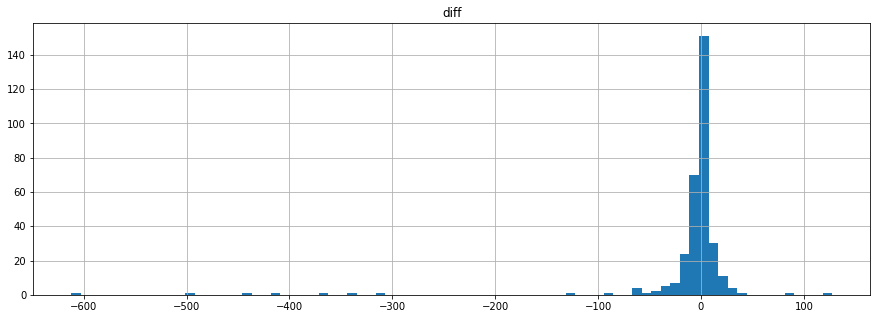

In [311]:
calc_pred.hist(column='diff',bins=80,figsize=(15,5))

In [312]:
len(calc_pred['diff'])

255885

In [313]:
calc_pred['TopTarget_Pick_pred_DEPT_pred'].value_counts()

472.000     2295
451.500     1982
431.500     1918
433.250     1794
464.750     1682
196.000     1461
405.744     1147
192.401     1135
416.590     1134
606.712     1118
250.000     1112
280.250     1101
303.000     1101
435.750     1101
460.000     1101
349.750     1101
371.500     1101
477.750     1081
315.500     1061
392.880     1061
703.750     1061
457.750     1061
564.722     1050
334.750     1041
309.750     1041
435.500     1040
670.008     1030
489.000     1024
495.000     1021
337.750     1021
560.500     1021
738.189     1020
749.756     1013
603.346     1013
561.664     1013
327.250     1012
860.000     1005
248.750     1001
800.000     1001
543.750     1001
598.760      989
267.000      989
444.532      988
460.090      988
71.500       986
554.000      985
643.250      981
628.500      981
345.500      981
482.250      981
329.500      969
710.756      964
464.214      963
483.000      961
132.000      961
323.750      961
564.500      961
587.750      961
597.500      9

In [314]:
print("the number of wells that ")

the number of wells that 


In [315]:
calc_pred_TopMcMr_Pick_pred_DEPT_pred = calc_pred.groupby( ["UWI"])['TopTarget_Pick_pred_DEPT_pred'].mean().to_frame().reset_index()


In [316]:
calc_pred_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'].value_counts()

20.000      3
472.000     3
250.000     2
196.000     2
433.250     2
431.500     2
71.500      2
451.500     2
464.750     2
590.096     1
402.500     1
396.500     1
457.750     1
1150.000    1
471.500     1
459.250     1
480.500     1
363.390     1
294.500     1
329.500     1
392.500     1
703.750     1
456.500     1
315.500     1
465.250     1
477.750     1
122.601     1
538.750     1
587.750     1
468.483     1
325.670     1
453.560     1
561.664     1
319.448     1
204.520     1
323.698     1
192.401     1
192.401     1
671.286     1
500.694     1
334.750     1
275.501     1
488.500     1
671.670     1
482.250     1
451.750     1
453.250     1
233.170     1
603.346     1
524.500     1
497.750     1
180.201     1
513.500     1
398.254     1
418.754     1
564.500     1
670.008     1
435.750     1
150.400     1
479.750     1
543.750     1
355.082     1
597.500     1
203.750     1
398.500     1
386.241     1
279.500     1
533.000     1
345.138     1
515.750     1
236.250     1
464.21

## The prediction are off in large part because a few wells have no prediction at all, which is treated as a zero! In real life, we would happily know we can't predict those wells with this model (by virtue of getting a zero for them) and ignore them, so let's use that in our stats too!

In [317]:
calc_pred_noZeros = calc_pred.loc[calc_pred['TopTarget_Pick_pred_classRollMeanSum'] != 0]

In [318]:
len(calc_pred_noZeros)

244612

In [319]:
# print(list(calc_pred_noZeros.groupby(['UWI'])['TopMcMr_Pick_predclassRollMeanSum_y']))

In [320]:
calc_pred_noZeros.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,diff
0,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224,0.0,0.0,0.0,0.0,449.474,361.363636,6.500
1,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474,0.0,0.0,0.0,0.0,449.474,361.363636,0.000
2,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724,0.0,0.0,0.0,0.0,449.474,361.363636,24.500
3,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974,0.0,0.0,0.0,0.0,449.474,361.363636,12.000
4,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224,0.0,0.0,0.0,0.0,449.474,361.363636,13.602


In [321]:
calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred = calc_pred_noZeros.groupby( ["UWI"])['TopTarget_Pick_pred_DEPT_pred'].mean().to_frame().reset_index()
calc_pred_noZeros_TopTarget_DEPTH = calc_pred_noZeros.groupby( ["UWI"] )['TopTarget_DEPTH'].mean().to_frame().reset_index()



In [322]:
calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred

,UWI,TopTarget_Pick_pred_DEPT_pred
0,00/01-04-075-23W4/0,624.500
1,00/01-12-079-14W4/0,454.000
2,00/01-25-083-02W4/0,196.000
3,00/01-27-079-23W4/0,429.000
4,00/02-05-076-26W4/0,792.898
5,00/02-07-076-13W4/0,513.500
6,00/02-22-071-22W4/0,595.500
7,00/02-32-089-12W4/0,196.000
8,00/03-02-084-17W4/0,266.801
9,00/03-04-072-09W4/0,470.750


In [323]:
calc_pred_noZeros_TopTarget_DEPTH

,UWI,TopTarget_DEPTH
0,00/01-04-075-23W4/0,631.00
1,00/01-12-079-14W4/0,454.00
2,00/01-25-083-02W4/0,220.50
3,00/01-27-079-23W4/0,441.00
4,00/02-05-076-26W4/0,806.50
5,00/02-07-076-13W4/0,519.00
6,00/02-22-071-22W4/0,593.50
7,00/02-32-089-12W4/0,220.50
8,00/03-02-084-17W4/0,283.00
9,00/03-04-072-09W4/0,471.00


In [324]:
score = mean_squared_error(calc_pred_noZeros_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])

In [325]:
score

147.26678914899935

In [326]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [327]:
r2_score = r2_score(calc_pred_noZeros_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
r2_score

0.9947379948764857

In [328]:
mean_absolute_error = mean_absolute_error(calc_pred_noZeros_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
mean_absolute_error

7.4610761589402825

In [329]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [330]:
calc_pred_noZeros['diff'] = calc_pred_noZeros_TopTarget_DEPTH['TopTarget_DEPTH'] - calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred']

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20d7b320>]],
      dtype=object)

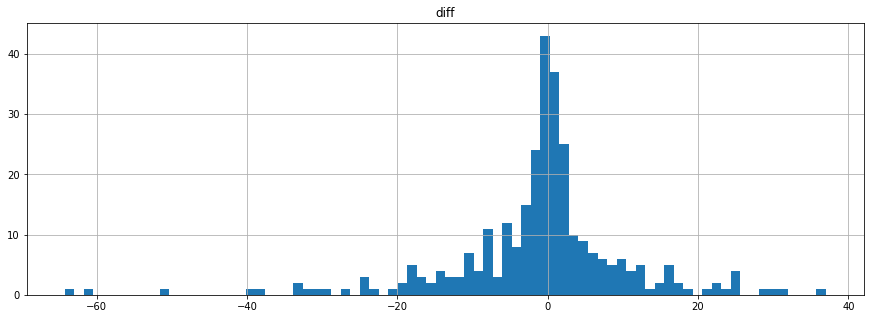

In [331]:
calc_pred_noZeros.hist(column='diff',bins=80,figsize=(15,5))

In [332]:
mean_error = calc_pred_noZeros['diff'].mean()
mean_error

-1.1611821192055352

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c35b551d0>]],
      dtype=object)

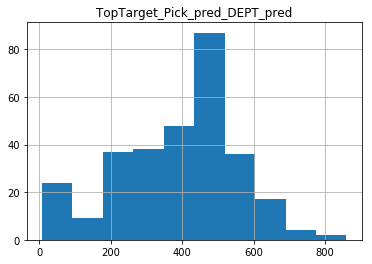

In [333]:
calc_pred_noZeros_TopMcMr_Pick_pred_DEPT_pred.hist(column='TopTarget_Pick_pred_DEPT_pred')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c35c1f5f8>]],
      dtype=object)

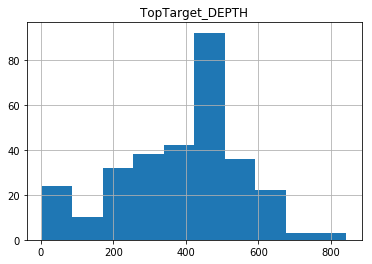

In [334]:
calc_pred_noZeros_TopTarget_DEPTH.hist(column='TopTarget_DEPTH')

THe quality controls are (-1) no pick, pick is unknown, or no data available, (0) pick is missing or eroded, high degree of condience based on a complete dataset and log suite, (1) good pick, with a high degree of condience based on geophysical log correlation and core control, (2) pick is highly interpretitve, but confirmed by surrounding wells (3) pick is uncertain, due to poor or missing data and/or low degree of confidence in correlation, and (4) pick is based on primary on drillers logs or other reliable drilling information.

# Now let's try that with ML instead of taking that max sum mean column thingy

In [335]:
calc_pred[680:780]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,diff
680,0,70,00/10-27-076-11W4/0,test,0,446.23,438.224,70.00,70.000000,54.090909,264.090909,449.474,361.363636,NaN
681,0,70,00/10-27-076-11W4/0,test,0,446.23,438.474,70.00,70.000000,57.272727,267.272727,449.474,361.363636,NaN
682,0,70,00/10-27-076-11W4/0,test,0,446.23,438.724,70.00,70.000000,60.454545,270.454545,449.474,361.363636,NaN
683,0,70,00/10-27-076-11W4/0,test,0,446.23,438.974,70.00,70.000000,63.636364,273.636364,449.474,361.363636,NaN
684,0,70,00/10-27-076-11W4/0,test,0,446.23,439.224,70.00,70.000000,66.818182,276.818182,449.474,361.363636,NaN
685,0,70,00/10-27-076-11W4/0,test,0,446.23,439.474,70.00,70.000000,70.000000,280.000000,449.474,361.363636,NaN
686,0,70,00/10-27-076-11W4/0,test,0,446.23,439.724,70.00,70.000000,70.000000,280.000000,449.474,361.363636,NaN
687,0,70,00/10-27-076-11W4/0,test,0,446.23,439.974,70.00,70.000000,70.000000,280.000000,449.474,361.363636,NaN
688,0,70,00/10-27-076-11W4/0,test,0,446.23,440.224,70.00,70.000000,70.000000,280.000000,449.474,361.363636,NaN
689,0,70,00/10-27-076-11W4/0,test,0,446.23,440.474,70.00,70.000000,70.000000,280.000000,449.474,361.363636,NaN


In [336]:
len(calc_pred)

255885

1. regression to predict distance between actual pick and each depth, then finding max for each well
2. regression, same as 1 but only for top 20 predictions in each well?
3. Class prediction, one pick per well and class is pick or not pick..but then still left with multiple per well?

## Part 2b: First step, run the rolling mean etc. functions on the train dataset

In [337]:
df_results_train_.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [338]:
df_results_train_wIndex = pd.concat([df_results_train_, train_index], axis=1)

In [339]:
df_results_train_wIndex[2200:2300]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH
2200,60,60,00/11-30-073-13W4/0,train,60,504.00
2201,60,60,00/11-30-073-13W4/0,train,60,504.00
2202,60,60,00/11-30-073-13W4/0,train,60,504.00
2203,60,60,00/11-30-073-13W4/0,train,60,504.00
2204,60,60,00/11-30-073-13W4/0,train,60,504.00
2205,60,60,00/11-30-073-13W4/0,train,60,504.00
2206,60,60,00/11-30-073-13W4/0,train,60,504.00
2207,60,60,00/11-30-073-13W4/0,train,60,504.00
2208,60,60,00/11-30-073-13W4/0,train,60,504.00
2209,60,60,00/11-30-073-13W4/0,train,60,504.00


In [340]:
df_results_train_wIndex = pd.concat([df_results_train_wIndex, train_X[['DEPT']]], axis=1)

In [341]:
df_results_train_wIndex[470:800]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT
470,70,70,00/11-19-073-16W4/0,train,70,422.76,419.994
471,70,70,00/11-19-073-16W4/0,train,70,422.76,420.244
472,70,70,00/11-19-073-16W4/0,train,70,422.76,420.494
473,70,70,00/11-19-073-16W4/0,train,70,422.76,420.744
474,70,70,00/11-19-073-16W4/0,train,70,422.76,420.994
475,70,95,00/11-19-073-16W4/0,train,70,422.76,421.244
476,70,100,00/11-19-073-16W4/0,train,70,422.76,421.494
477,70,95,00/11-19-073-16W4/0,train,70,422.76,421.744
478,70,95,00/11-19-073-16W4/0,train,70,422.76,421.994
479,70,95,00/11-19-073-16W4/0,train,70,422.76,422.244


In [342]:
def calcPredVsRealTopDif(df,depth_str,pick_pred_class_str,UWI_str,rollingWindows,predClasses):
    """
    Function takes in:
        A dataframe with predictions and dataframe with UWIs and known pick depths. Dataframes may not be same length but df 2 must have all UWIs in df 1.
    Function returns:
        A column for predicted dataframe with calculated single prediction depth pick based on the median row technique
        A column for predicted dataframe with calculated single prediction depth pick based on rolling means of classes predicted for each row.
    THESE BELOW ARE NOTE YET IMPLIMENTED!    
        A new dataframe that is just one row per well and includes as col of UWIs, known picks, predicted picks, and difference
        A new col in the new df that has high and low error by some metric?
        A score of mean abosolute error across all wells in the given dataframe 1.
    """

    df_merges = df.copy()
    all_new_rolling_mean_col = []
    for Window in rollingWindows:
        new_col = pick_pred_class_str+'_classRollMean'+str(Window)
        all_new_rolling_mean_col.append(new_col)
        half_window_neg = -1*math.floor(Window/2)
        df_merges[new_col] = df_merges.groupby([UWI_str])[pick_pred_class_str].shift(half_window_neg).rolling(Window).mean().fillna(0)
    df_merges[pick_pred_class_str+'classRollMeanSum'] = 0
    for col in all_new_rolling_mean_col:
        df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[col]
    df_merges[pick_pred_class_str+'classRollMeanSum'] += df_merges[pick_pred_class_str]
    idx = df_merges.loc[df_merges.groupby([UWI_str])[pick_pred_class_str+'classRollMeanSum'].idxmax()] 
    #print('idx=',idx)
    print('type(idx)',type(idx))
#     print(idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']])
    max_frame = idx[['UWI','DEPT',pick_pred_class_str+'classRollMeanSum']]
    print("columns of max_frame are:",max_frame.columns)
    max_frame.columns = ['UWI',pick_pred_class_str+'_DEPT_pred',pick_pred_class_str+'_classRollMeanSum']
    #print("type",type(max_series),"and max series is ",max_series)
    print("columns of df_merges are:",df_merges.columns)
    print("columns of max_frame are:",max_frame.columns)
    df_merges = pd.merge(df_merges,max_frame, on='UWI', how='outer')
    return df_merges
    

In [343]:
len(df_results_train_wIndex)

217602

In [344]:
calc_pred_train = calcPredVsRealTopDif(df_results_train_wIndex,'DEPT','TopTarget_Pick_pred','UWI',[4,6,22],[0,60,70,95,100])

type(idx) <class 'pandas.core.frame.DataFrame'>
columns of max_frame are: Index(['UWI', 'DEPT', 'TopTarget_Pick_predclassRollMeanSum'], dtype='object')
columns of df_merges are: Index(['class_DistFrPick_TopTarget', 'TopTarget_Pick_pred', 'UWI', 'trainOrTest', 'class_DistFrPick_TopTarget', 'TopTarget_DEPTH', 'DEPT', 'TopTarget_Pick_pred_classRollMean4', 'TopTarget_Pick_pred_classRollMean6', 'TopTarget_Pick_pred_classRollMean22', 'TopTarget_Pick_predclassRollMeanSum'], dtype='object')
columns of max_frame are: Index(['UWI', 'TopTarget_Pick_pred_DEPT_pred', 'TopTarget_Pick_pred_classRollMeanSum'], dtype='object')


In [345]:
calc_pred_train[460:800]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
460,60,60,00/07-23-076-22W4/0,train,60,630.33,634.364,60.00,60.000000,66.136364,246.136364,629.864,380.454545
461,60,60,00/07-23-076-22W4/0,train,60,630.33,634.614,60.00,60.000000,67.727273,247.727273,629.864,380.454545
462,60,60,00/07-23-076-22W4/0,train,60,630.33,634.864,60.00,60.000000,67.727273,247.727273,629.864,380.454545
463,60,60,00/07-23-076-22W4/0,train,60,630.33,635.114,60.00,65.833333,67.727273,253.560606,629.864,380.454545
464,0,60,00/07-23-076-22W4/0,train,0,630.33,635.364,68.75,55.833333,67.727273,252.310606,629.864,380.454545
465,0,60,00/07-23-076-22W4/0,train,0,630.33,637.864,53.75,45.833333,67.727273,227.310606,629.864,380.454545
466,0,95,00/07-23-076-22W4/0,train,0,630.33,640.364,38.75,35.833333,67.727273,237.310606,629.864,380.454545
467,0,0,00/07-23-076-22W4/0,train,0,630.33,642.864,23.75,41.666667,67.727273,133.143939,629.864,380.454545
468,0,0,00/07-23-076-22W4/0,train,0,630.33,645.364,23.75,47.500000,69.318182,140.568182,629.864,380.454545
469,0,0,00/07-23-076-22W4/0,train,0,630.33,647.864,47.50,47.500000,70.909091,165.909091,629.864,380.454545


## THERE IS SOMETHING WRONG IN HERE WHEN I TRY TO USE THE TRAIN DATAFRAME! I GET REPEATS IN THE DEPTH COLUMNS AT THE DEPTH OF THE PICK! AND I CAN"T FIGURE OUT WHY FOR NOW I"M TAKING THEM OUT MANUALLY!

In [346]:
len(calc_pred)

255885

In [347]:
len(calc_pred_train)

217602

In [348]:
# calc_pred_train['DEPT_shift'] = calc_pred_train['DEPT'].shift(+1)
# calc_pred_train['DEPT_shiftDistInDepth'] = calc_pred_train['DEPT']-calc_pred_train['DEPT_shift']
# calc_pred_train['DEPT_shiftDistInDepth'].abs()
# calc_pred_train['DEPT_diff]
# calc_pred_train['UWI_shiftDown'] = calc_pred_train['UWI'].shift(+1)


In [349]:
calc_pred_train.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-32-080-20W4/0,train,0,377.95,149.602,0.0,0.0,0.0,0.0,377.602,384.848485
1,0,0,00/10-32-080-20W4/0,train,0,377.95,152.102,0.0,0.0,0.0,0.0,377.602,384.848485
2,0,0,00/10-32-080-20W4/0,train,0,377.95,154.602,0.0,0.0,0.0,0.0,377.602,384.848485
3,0,0,00/10-32-080-20W4/0,train,0,377.95,157.102,0.0,0.0,0.0,0.0,377.602,384.848485
4,0,0,00/10-32-080-20W4/0,train,0,377.95,159.602,0.0,0.0,0.0,0.0,377.602,384.848485


In [350]:
# calc_pred_train['DEPT_shiftDistInDepth'].value_counts()

### Nevermind, I forgot I doubled the rows for certain depths to rebalance the columns!!!! duh!!

In [351]:
calc_pred_train_TopMcMr_Pick_pred_DEPT_pred = calc_pred_train.groupby( ["UWI"])['TopTarget_Pick_pred_DEPT_pred'].mean().to_frame().reset_index()
calc_pred_train_TopTarget_DEPTH = calc_pred_train.groupby( ["UWI"] )['TopTarget_DEPTH'].mean().to_frame().reset_index()

In [352]:
calc_pred_train.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum
0,0,0,00/10-32-080-20W4/0,train,0,377.95,149.602,0.0,0.0,0.0,0.0,377.602,384.848485
1,0,0,00/10-32-080-20W4/0,train,0,377.95,152.102,0.0,0.0,0.0,0.0,377.602,384.848485
2,0,0,00/10-32-080-20W4/0,train,0,377.95,154.602,0.0,0.0,0.0,0.0,377.602,384.848485
3,0,0,00/10-32-080-20W4/0,train,0,377.95,157.102,0.0,0.0,0.0,0.0,377.602,384.848485
4,0,0,00/10-32-080-20W4/0,train,0,377.95,159.602,0.0,0.0,0.0,0.0,377.602,384.848485


In [353]:
calc_pred_train_TopMcMr_Pick_pred_DEPT_pred.head()

,UWI,TopTarget_Pick_pred_DEPT_pred
0,00/01-01-073-05W5/0,607.000
1,00/01-03-085-15W4/0,242.501
2,00/01-05-085-15W4/0,253.000
3,00/01-08-080-21W4/0,411.000
4,00/01-09-080-13W4/0,441.000


In [354]:
calc_pred_train_TopTarget_DEPTH.head()

,UWI,TopTarget_DEPTH
0,00/01-01-073-05W5/0,607.0
1,00/01-03-085-15W4/0,243.0
2,00/01-05-085-15W4/0,253.0
3,00/01-08-080-21W4/0,411.0
4,00/01-09-080-13W4/0,441.0


In [355]:
type(calc_pred_train_TopTarget_DEPTH)

pandas.core.frame.DataFrame

In [356]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [357]:
# r2_score_train_wZeros = r2_score(calc_pred_train_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_train_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
# r2_score_train_wZeros

r2_score_train_wZeros = r2_score(calc_pred_train_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_train_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
r2_score_train_wZeros

0.873268894588701

In [358]:
mean_absolute_error_train_wZeros = mean_absolute_error(calc_pred_train_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_train_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
mean_absolute_error_train_wZeros

7.606963281249952

## Part 2b: First step appendum: Add column for regression target of distance between depth and real pick depth

In [359]:

calc_pred_train['TopTarget_DEPTH_minus_DEPT'] = calc_pred_train['TopTarget_DEPTH'] - calc_pred_train['DEPT']

In [360]:
calc_pred_train[2740:2750]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_DEPTH_minus_DEPT
2740,95,70,00/06-08-074-11W4/0,train,95,472.44,471.954,82.50,82.500000,82.500000,317.500000,472.204,380.227273,0.486
2741,95,95,00/06-08-074-11W4/0,train,95,472.44,472.204,88.75,86.666667,83.636364,354.053030,472.204,380.227273,0.236
2742,95,95,00/06-08-074-11W4/0,train,95,472.44,472.454,95.00,90.833333,84.772727,365.606061,472.204,380.227273,-0.014
2743,95,95,00/06-08-074-11W4/0,train,95,472.44,472.704,95.00,95.000000,85.909091,370.909091,472.204,380.227273,-0.264
2744,60,95,00/06-08-074-11W4/0,train,60,472.44,472.954,95.00,95.000000,85.454545,370.454545,472.204,380.227273,-0.514
2745,60,95,00/06-08-074-11W4/0,train,60,472.44,473.204,95.00,95.000000,85.000000,370.000000,472.204,380.227273,-0.764
2746,60,95,00/06-08-074-11W4/0,train,60,472.44,473.454,95.00,95.000000,84.545455,369.545455,472.204,380.227273,-1.014
2747,60,95,00/06-08-074-11W4/0,train,60,472.44,473.704,95.00,95.000000,84.090909,369.090909,472.204,380.227273,-1.264
2748,60,95,00/06-08-074-11W4/0,train,60,472.44,473.954,95.00,95.000000,83.636364,368.636364,472.204,380.227273,-1.514
2749,60,95,00/06-08-074-11W4/0,train,60,472.44,474.204,95.00,95.000000,84.772727,369.772727,472.204,380.227273,-1.764


## Part 2b: Second step, train model for train dataset

### Let's make a column for top predicted pick depth from rolling mean minus each row depth

In [361]:

calc_pred_train['TopTarget_Pick_pred_DEPT_pred_minus_DEPT'] = calc_pred_train['TopTarget_Pick_pred_DEPT_pred'] - calc_pred_train['DEPT']

In [362]:
#calc_pred_train.drop(['TopTarget_DEPTH_minus_TopTarget_DEPTH'],axis=1)

In [363]:
calc_pred_train[3300:3400]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_DEPTH_minus_DEPT,TopTarget_Pick_pred_DEPT_pred_minus_DEPT
3300,60,70,00/11-23-080-04W4/0,train,60,259.99,261.821,65.00,65.000000,73.863636,273.863636,259.688,382.537879,-1.831,-2.133
3301,60,60,00/11-23-080-04W4/0,train,60,259.99,262.126,62.50,63.333333,70.681818,256.515152,259.688,382.537879,-2.136,-2.438
3302,60,60,00/11-23-080-04W4/0,train,60,259.99,262.431,60.00,61.666667,67.500000,249.166667,259.688,382.537879,-2.441,-2.743
3303,60,60,00/11-23-080-04W4/0,train,60,259.99,262.736,60.00,60.000000,63.181818,243.181818,259.688,382.537879,-2.746,-3.048
3304,60,60,00/11-23-080-04W4/0,train,60,259.99,263.040,60.00,60.000000,58.863636,238.863636,259.688,382.537879,-3.050,-3.352
3305,60,60,00/11-23-080-04W4/0,train,60,259.99,263.345,60.00,65.833333,54.545455,240.378788,259.688,382.537879,-3.355,-3.657
3306,60,60,00/11-23-080-04W4/0,train,60,259.99,263.650,68.75,71.666667,50.227273,250.643939,259.688,382.537879,-3.660,-3.962
3307,60,60,00/11-23-080-04W4/0,train,60,259.99,263.955,77.50,71.666667,45.909091,255.075758,259.688,382.537879,-3.965,-4.267
3308,60,95,00/11-23-080-04W4/0,train,60,259.99,264.260,77.50,71.666667,42.727273,286.893939,259.688,382.537879,-4.270,-4.572
3309,60,95,00/11-23-080-04W4/0,train,60,259.99,264.565,77.50,61.666667,39.545455,273.712121,259.688,382.537879,-4.575,-4.877


In [364]:
len(calc_pred_train)

217602

In [365]:
columnsDoNotNeedFor2ML = ['class_DistFrPick_TopTarget','trainOrTest','UWI','class_DistFrPick_TopTarget','TopTarget_DEPTH','DEPT','TopTarget_DEPTH_minus_DEPT']



In [366]:
columnsLabels2ML = ['UWI','trainOrTest','DEPT']

In [367]:
calc_pred_train_forMLtrain = calc_pred_train.drop(columnsDoNotNeedFor2ML,axis=1)


In [368]:
calc_pred_train_forMLtrain_indexLabels = calc_pred_train[columnsLabels2ML]
# 

In [369]:
calc_pred_train_forMLtrain.head()

,TopTarget_Pick_pred,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_Pick_pred_DEPT_pred_minus_DEPT
0,0,0.0,0.0,0.0,0.0,377.602,384.848485,228.0
1,0,0.0,0.0,0.0,0.0,377.602,384.848485,225.5
2,0,0.0,0.0,0.0,0.0,377.602,384.848485,223.0
3,0,0.0,0.0,0.0,0.0,377.602,384.848485,220.5
4,0,0.0,0.0,0.0,0.0,377.602,384.848485,218.0


In [370]:
len(calc_pred_train_forMLtrain)

217602

In [371]:
calc_pred_train_forMLtarget = calc_pred_train[['TopTarget_DEPTH_minus_DEPT']]

In [372]:
calc_pred_train_forMLtarget.head()

,TopTarget_DEPTH_minus_DEPT
0,228.348
1,225.848
2,223.348
3,220.848
4,218.348


In [373]:
len(calc_pred_train_forMLtarget)

217602

## Part 2b:: Fourth step, predict using test dataset

In [374]:
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT
11203,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224
11204,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474
11205,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724
11206,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974
11207,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224


## Part 2b: Third step, predict using train dataset

In [375]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [376]:
calc_pred_train_forMLtrain

,TopTarget_Pick_pred,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_Pick_pred_DEPT_pred_minus_DEPT
0,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,228.00
1,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,225.50
2,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,223.00
3,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,220.50
4,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,218.00
5,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,215.50
6,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,213.00
7,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,210.50
8,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,208.00
9,0,0.00,0.000000,0.000000,0.000000,377.602,384.848485,205.50


In [377]:
calc_pred_train_forMLtarget

,TopTarget_DEPTH_minus_DEPT
0,228.348
1,225.848
2,223.348
3,220.848
4,218.348
5,215.848
6,213.348
7,210.848
8,208.348
9,205.848


In [378]:
len(calc_pred_train_forMLtarget)

217602

In [379]:
X = calc_pred_train_forMLtrain.values
Y = calc_pred_train_forMLtarget['TopTarget_DEPTH_minus_DEPT'].values.ravel()

In [380]:
len(X)

217602

In [381]:
len(Y)

217602

In [382]:
seed = 7
test_size = 0.10
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [383]:
model = XGBRegressor()


In [384]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [385]:
y_pred = model.predict(X_test)

In [386]:
y_pred

array([  0.05954918,  -0.18110847,   0.05954918, ...,  -0.95405006,
         1.9067343 , -10.108047  ], dtype=float32)

In [387]:
y_pred.mean()

22.388077

In [388]:
y_test.mean()

22.370475897247367

In [389]:
y_test[0]

0.0

In [390]:
y_pred[0]

0.059549183

In [391]:
y_test[100]

0.75

In [392]:
y_pred[100]

0.772802

In [393]:
test_pred_dist_diff = y_test - y_pred

In [394]:
import matplotlib.pyplot as plt

The plot is: For each row, the distance between the predicted distance between that row's depth and the actual pick depth in that row 

but only for training data that was used in this regression model

(array([3.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 5.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00, 6.000e+00, 7.000e+00, 1.000e+00, 7.000e+00,
        1.300e+01, 1.500e+01, 1.500e+01, 2.300e+01, 3.600e+01, 3.600e+01,
        5.100e+01, 7.200e+01, 1.040e+02, 1.690e+02, 2.200e+02, 3.010e+02,
        3.770e+02, 4.360e+02, 5.690e+02, 1.034e+03, 1.760e+03, 8.313e+03,
        2.571e+03, 1.424e+03, 8.470e+02, 6.510e+02, 6.070e+02, 4.370e+02,
        3.710e+02, 2.420e+02, 2.180e+02, 1.140e+02, 8.300e+01, 7.700e+01,
        5.000e+01, 2.300e+01, 1.700e+01, 6.000e+00, 4.000e+00, 8.000e+00,
        6.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 7.000e+00,
        4.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00]),
 array([-10.        ,  -9.66666667,  -9.33333333,  -9.        ,
         -8.66666667,  -8.33333333,  -8.        ,  -7.66666667,
         -7.33333333,  -7.        ,  -6.66666667,  -6.33333333,
         -6.        ,  -5.66666667,  -5.33333333,  -5.        ,
  

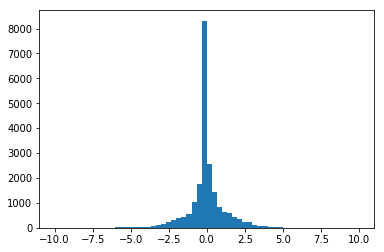

In [395]:
plt.hist(test_pred_dist_diff, bins=60,range=[-10, 10])

# Process test dataset for this

In [438]:
def prepFor2ndMLonTest(df_results_test_wIndex):
    calc_pred_test = calcPredVsRealTopDif(df_results_test_wIndex,'DEPT','TopTarget_Pick_pred','UWI',[4,6,22],[0,60,70,95,100])
    calc_pred_test_TopMcMr_Pick_pred_DEPT_pred = calc_pred_test.groupby( ["UWI"])['TopTarget_Pick_pred_DEPT_pred'].mean().to_frame().reset_index()
    calc_pred_test_TopTarget_DEPTH = calc_pred_test.groupby( ["UWI"] )['TopTarget_DEPTH'].mean().to_frame().reset_index()
    r2_score_test_wZeros = r2_score(calc_pred_test_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_test_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
    print("r2_score_test_wZeros = ",r2_score_test_wZeros)
    mean_absolute_error_test_wZeros = mean_absolute_error(calc_pred_test_TopTarget_DEPTH['TopTarget_DEPTH'], calc_pred_test_TopMcMr_Pick_pred_DEPT_pred['TopTarget_Pick_pred_DEPT_pred'])
    print("mean_absolute_error_test_wZeros",mean_absolute_error_test_wZeros)
    ####
    calc_pred_test['TopTarget_DEPTH_minus_DEPT'] = calc_pred_test['TopTarget_DEPTH'] - calc_pred_test['DEPT']
    calc_pred_test['TopTarget_Pick_pred_DEPT_pred_minus_DEPT'] = calc_pred_test['TopTarget_Pick_pred_DEPT_pred'] - calc_pred_test['DEPT']
    ####
    columnsDoNotNeedFor2ML = ['class_DistFrPick_TopTarget','trainOrTest','UWI','class_DistFrPick_TopTarget','TopTarget_DEPTH','DEPT','TopTarget_DEPTH_minus_DEPT']
    columnsLabels2ML = ['UWI','trainOrTest','DEPT']
    ####
    calc_pred_test_forMLtest = calc_pred_test.drop(columnsDoNotNeedFor2ML,axis=1)
    calc_pred_test_forMLtest_indexLabels = calc_pred_test[columnsLabels2ML]
    calc_pred_test_forMLtarget = calc_pred_test[['TopTarget_DEPTH_minus_DEPT']]
    ####
    print("print calc_pred_test_forMLtest.head()",calc_pred_test_forMLtest.head())
    Xtest = calc_pred_test_forMLtest.values
    Ytest = calc_pred_test_forMLtarget['TopTarget_DEPTH_minus_DEPT'].values.ravel()
    return Xtest,Ytest,calc_pred_test_forMLtest
#     seed = 7
#     test_size = 0.33
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
#     model = XGBRegressor()
#     model.fit(X,Y)

    
    

In [439]:
Xtest,Ytest,calc_pred_test_forMLtest = prepFor2ndMLonTest(df_results_test_wIndex)

type(idx) <class 'pandas.core.frame.DataFrame'>
columns of max_frame are: Index(['UWI', 'DEPT', 'TopTarget_Pick_predclassRollMeanSum'], dtype='object')
columns of df_merges are: Index(['class_DistFrPick_TopTarget', 'TopTarget_Pick_pred', 'UWI', 'trainOrTest', 'class_DistFrPick_TopTarget', 'TopTarget_DEPTH', 'DEPT', 'TopTarget_Pick_pred_classRollMean4', 'TopTarget_Pick_pred_classRollMean6', 'TopTarget_Pick_pred_classRollMean22', 'TopTarget_Pick_predclassRollMeanSum'], dtype='object')
columns of max_frame are: Index(['UWI', 'TopTarget_Pick_pred_DEPT_pred', 'TopTarget_Pick_pred_classRollMeanSum'], dtype='object')
r2_score_test_wZeros =  0.846861575770373
mean_absolute_error_test_wZeros 18.366585669781934
print calc_pred_test_forMLtest.head()    TopTarget_Pick_pred  TopTarget_Pick_pred_classRollMean4  TopTarget_Pick_pred_classRollMean6  TopTarget_Pick_pred_classRollMean22  TopTarget_Pick_predclassRollMeanSum  TopTarget_Pick_pred_DEPT_pred  TopTarget_Pick_pred_classRollMeanSum  TopTarget_Pi

In [440]:
def runModel2Predict(model,Xtest):    
    test_pred = model.predict(Xtest)
    test_pred_dist_diff = Ytest - test_pred
    print("mean_absolute_error",mean_absolute_error(test_pred, Ytest))
    return test_pred_dist_diff

In [441]:
testtest_pred_dist_diff = runModel2Predict(model,Xtest)

mean_absolute_error 10.915856294742483


In [446]:
calc_pred_test_forMLtest[700:800]

,TopTarget_Pick_pred,TopTarget_Pick_pred_classRollMean4,TopTarget_Pick_pred_classRollMean6,TopTarget_Pick_pred_classRollMean22,TopTarget_Pick_predclassRollMeanSum,TopTarget_Pick_pred_DEPT_pred,TopTarget_Pick_pred_classRollMeanSum,TopTarget_Pick_pred_DEPT_pred_minus_DEPT
700,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,6.25
701,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,6.00
702,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,5.75
703,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,5.50
704,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,5.25
705,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,5.00
706,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,4.75
707,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,4.50
708,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,4.25
709,70,70.00,70.000000,70.000000,280.000000,449.474,361.363636,4.00


In [434]:
testtest_pred_dist_diff

array([-1.91085486, -2.16085486, -2.41085486, ...,  9.75398141,
        9.50398141,  9.25398141])

In [435]:
len(testtest_pred_dist_diff)

255885

(array([  344.,   306.,   297.,   317.,   354.,   454.,   674.,   643.,
          436.,   566.,   965.,  1432.,  1466.,  1237.,  1176.,  1577.,
         1523.,  2083.,  3016.,  3788.,  3794.,  4340.,  4818.,  6077.,
         7465.,  8616., 10573., 14091., 20911., 29016., 32018., 22822.,
        12673.,  7718.,  6235.,  5822.,  4822.,  3541.,  2599.,  2921.,
         2315.,  1457.,  1326.,  1740.,  1958.,   950.,   451.,   601.,
          657.,   482.,   233.,   323.,   410.,   229.,   189.,   130.,
           93.,    93.,    84.,    82.]),
 array([-50.        , -48.33333333, -46.66666667, -45.        ,
        -43.33333333, -41.66666667, -40.        , -38.33333333,
        -36.66666667, -35.        , -33.33333333, -31.66666667,
        -30.        , -28.33333333, -26.66666667, -25.        ,
        -23.33333333, -21.66666667, -20.        , -18.33333333,
        -16.66666667, -15.        , -13.33333333, -11.66666667,
        -10.        ,  -8.33333333,  -6.66666667,  -5.        ,
      

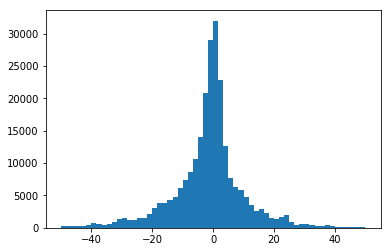

In [436]:
plt.hist(testtest_pred_dist_diff, bins=60,range=[-50, 50])

In [401]:
df_results_test_wIndex.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT
11203,0,0,00/10-27-076-11W4/0,test,0,446.23,268.224
11204,0,0,00/10-27-076-11W4/0,test,0,446.23,268.474
11205,0,0,00/10-27-076-11W4/0,test,0,446.23,268.724
11206,0,0,00/10-27-076-11W4/0,test,0,446.23,268.974
11207,0,0,00/10-27-076-11W4/0,test,0,446.23,269.224


In [402]:
len(df_results_test_wIndex)

255885

In [403]:
len(df_result_testtest)

255885

In [404]:
testtest_pred_dist_diff_indexValues = testtest_pred_dist_diff
df_result_testtest = pd.DataFrame(testtest_pred_dist_diff, index=testtest_pred_dist_diff_indexValues, columns=['TopTarget_Pred_RegressionDistDiffPred'])


In [405]:
df_result_testtest.index.is_unique

False

In [406]:
df_results_test_wIndex.index.is_unique

True

In [407]:
df_result_testtest_resetIndx = df_result_testtest.reset_index()

In [408]:
type(df_result_testtest_resetIndx)

pandas.core.frame.DataFrame

In [409]:
df_result_testtest_resetIndx.index.is_unique

True

In [410]:
len(df_result_testtest_resetIndx)

255885

In [411]:
len(df_result_testtest_resetIndx.index)

255885

In [412]:
type(df_result_testtest_resetIndx)

pandas.core.frame.DataFrame

In [413]:
#.index.is_unique

In [414]:
test_df_wRegDistDiffPred= pd.concat([df_results_test_wIndex, df_result_testtest_resetIndx], axis=1)

In [415]:
test_df_wRegDistDiffPred[600:800]

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,index,TopTarget_Pred_RegressionDistDiffPred
600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.942687,-2.942687
601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.192687,-3.192687
602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.442687,-3.442687
603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.692687,-3.692687
604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.942687,-3.942687
605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.192687,-4.192687
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.442687,-4.442687
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.876391,-0.876391
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.126391,-1.126391
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.376391,-1.376391


In [416]:
test_df_wRegDistDiffPred.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,index,TopTarget_Pred_RegressionDistDiffPred
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.910855,-1.910855
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.160855,-2.160855
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.410855,-2.410855
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.660855,-2.660855
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.910855,-2.910855


In [417]:
def findMin_TopTarget_Pred_RegressionDistDiffPred_byWell(df_merges,ColToMin):
    idx = df_merges.loc[df_merges.groupby(["UWI"])[ColToMin].idxmin()] 
    print('type(idx)',type(idx))
    max_frame = idx[['UWI','DEPT',ColToMin]]
    max_frame.columns = ['UWI','TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred',ColToMin]
    #print("type",type(max_series),"and max series is ",max_series)
    df_mergesResult = pd.merge(df_merges,max_frame, on='UWI', how='outer')
    return df_mergesResult

In [418]:
regression2ndMLRound_onTest = findMin_TopTarget_Pred_RegressionDistDiffPred_byWell(test_df_wRegDistDiffPred,"TopTarget_Pred_RegressionDistDiffPred")

/Users/justingosses/anaconda/envs/MannvilleDask2/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


type(idx) <class 'pandas.core.frame.DataFrame'>


In [419]:
type(regression2ndMLRound_onTest)

pandas.core.frame.DataFrame

In [420]:
regression2ndMLRound_onTest.head()

,class_DistFrPick_TopTarget,TopTarget_Pick_pred,UWI,trainOrTest,class_DistFrPick_TopTarget,TopTarget_DEPTH,DEPT,index,TopTarget_Pred_RegressionDistDiffPred_x,TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred,TopTarget_Pred_RegressionDistDiffPred_y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.910855,-1.910855,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.910855,-1.910855,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.910855,-1.910855,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.910855,-1.910855,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.910855,-1.910855,NaN,NaN


In [421]:
len(regression2ndMLRound_onTest)

51645419

In [422]:
#df[(df>=0)&(df<=20)].dropna()

regression2ndMLRound_onTest_onePerWell = regression2ndMLRound_onTest[regression2ndMLRound_onTest['TopTarget_Pred_RegressionDistDiffPred_Min_DEPT_pred']==regression2ndMLRound_onTest['DEPT']].dropna()

In [423]:
len(regression2ndMLRound_onTest_onePerWell)

67

In [424]:
len(regression2ndMLRound_onTest['UWI'].unique())

322

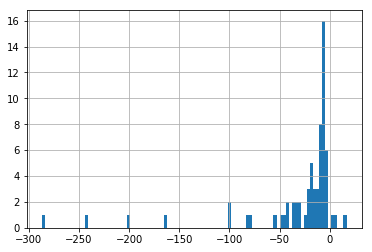

In [425]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_x'].hist(bins=100)

In [426]:
regression2ndMLRound_onTest_onePerWell['TopTarget_Pred_RegressionDistDiffPred_x'].mean()

-31.402317953963777

In [427]:
mean_absolute_error_test2ndRoundML_wZeros = mean_absolute_error(regression2ndMLRound_onTest_onePerWell['TopTarget_DEPTH'], regression2ndMLRound_onTest_onePerWell['DEPT'])


In [428]:
mean_absolute_error_test2ndRoundML_wZeros

83.96798507462685